# Solumetric: *main*

In [7]:
import deepchem as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch

import sys
import logging
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler(stream=sys.stdout))
logger.info("test")

import warnings
warnings.filterwarnings("once")

In [15]:
# specify featurizer, splitter, and transformers

FEATURIZER = dc.feat.MolGraphConvFeaturizer(use_edges=True)
# FEATURIZER = dc.feat.CircularFingerprint(radius=4, size=2048, chiral=True, bonds=True)

# SPLITTER = dc.splits.RandomSplitter()
SPLITTER = dc.splits.RandomStratifiedSplitter()

TRANSFORMERS = ["normalization"]

# load in Delaney dataset
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer=FEATURIZER, 
                                                       splitter=SPLITTER,
                                                       transformers=TRANSFORMERS,
                                                       reload=True,
                                                       data_dir="data",
                                                       save_dir="data",
                                                       seed=42,
                                                       log_every_n=1,
                                                       frac_train=0.8,
                                                       frac_valid=0.1,
                                                       frac_test=0.1)
train_dataset, valid_dataset, test_dataset = datasets

In [16]:
train_dataset.X.shape, valid_dataset.X.shape, test_dataset.X.shape

((902,), (113,), (112,))

In [17]:
# ensure y is normalised
# plt.hist(train_dataset.y, bins=50);
np.testing.assert_allclose((train_dataset.y.mean(), train_dataset.y.std()),
                           (0.0, 1.0),
                           atol=1e-7)

In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
METRICS = [dc.metrics.Metric(dc.metrics.rms_score),
           dc.metrics.Metric(dc.metrics.mean_absolute_error),
           dc.metrics.Metric(dc.metrics.r2_score),]

SPLIT_TO_DATASET = dict(train=train_dataset,
                        valid=valid_dataset,
                        test=test_dataset)

In [20]:
BATCH_SIZE = 32
MAX_EPOCHS = 200
REPLICATES = 5
PATIENCE = 16

In [21]:
# convenience function to initialise new model
def get_model():
    LOSS = dc.models.losses.L2Loss()
    OPTIMIZER = dc.models.optimizers.Adam()
    model = dc.models.torch_models.MPNNModel(n_tasks=1,
                                             mode='regression', 
                                             node_out_feats=64,
                                             edge_hidden_feats=128,
                                             num_step_message_passing=3,
                                             num_step_set2set=6,
                                             num_layer_set2set=3,
                                             number_atom_features=30,
                                             number_bond_features=11,
                                             batch_size=BATCH_SIZE,
                                             device="cpu",
                                             optimizer=OPTIMIZER,
                                             seed=42,
                                             log_frequency=1,
                                             model_dir="model",)
    """
    xgboost_model = xgboost.XGBRegressor(n_estimators=100,
                                         objective="reg:squarederror",
                                         random_state=42,
                                         device="cpu",)
    model = dc.models.gbdt_models.GBDTModel(xgboost_model,
                                            model_dir="model_xgboost",)
    """
                                            
                                 
    return model

# convenience function to initialise early stopper
def get_early_stopper():
    early_stopper = EarlyStopper(patience=PATIENCE,
                                 min_delta=0)
    return early_stopper

In [5]:
from IPython.display import clear_output

def run_benchmarking():

    # final outputs from benchmarking
    outputs = dict(train_losses=[], train_errors=[], valid_errors=[], metrics=[], models=[])
    # iterate over replicates
    for replicate in range(REPLICATES):
        # initialise new model and early stopper
        model = get_model()
        early_stopper = get_early_stopper()
        # per-replicate logging
        train_losses = []
        train_errors = []
        valid_errors = []
        # log
        print(f"Run {replicate+1:2d}/{REPLICATES:2d}")
        # iterate over epochs
        for epoch in range(1, MAX_EPOCHS):
            # train 1 epoch
            batch_generator = model.default_generator(train_dataset,
                                                      epochs=1,
                                                      mode="fit",
                                                      deterministic=False,
                                                      pad_batches=False)
            loss = model.fit_generator(batch_generator, all_losses=train_losses,) # appends losses to train_losses
            # track stats
            train_mse = model.evaluate(train_dataset, METRICS, transformers)["rms_score"]
            valid_mse = model.evaluate(valid_dataset, METRICS, transformers)["rms_score"]
            # check for early stop criterion
            if early_stopper.early_stop(valid_mse):
                break
            # log errors
            if epoch == 1:
                print(f"Epoch {epoch:3d} | {valid_mse:.4f} | {early_stopper.counter:2d}")
            else:
                print(f"Epoch {epoch:3d} | {valid_errors[-1]:.4f} --> {valid_mse:.4f} | {early_stopper.counter:2d}")
            train_errors.append(train_mse)
            valid_errors.append(valid_mse)
        # add losses/errors to final output
        outputs["train_losses"].append(train_losses)
        outputs["train_errors"].append(train_errors)
        outputs["valid_errors"].append(valid_errors)

        metrics = {}
        for split in "train", "valid", "test":
            dataset = split_to_dataset[split]
            metrics[split] = model.evaluate(dataset, METRICS, transformers)
        outputs["metrics"].append(metrics)

        # save model
        outputs["models"].append(model)

        # clear iPython output
        clear_output(wait=True)
        
    return outputs

outputs = run_benchmarking()
outputs

NameError: name 'dc' is not defined

In [426]:
print(f"Total training batches: {model.get_global_step()}")

Total training batches: 1455


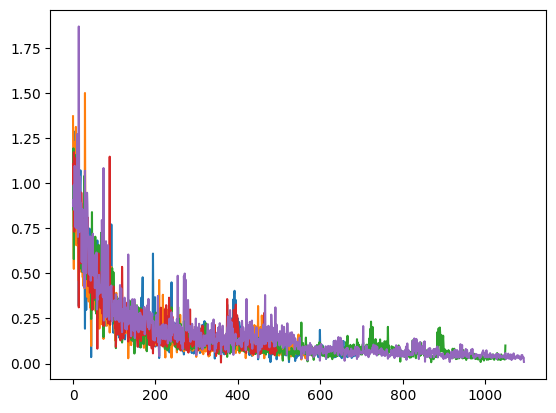

In [431]:
for i in range(REPLICATES):
    plt.plot(outputs["train_losses"][i])

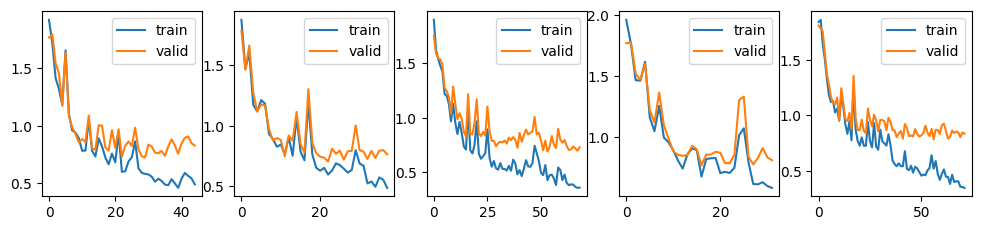

In [432]:
fig = plt.figure(figsize=(12, 12/REPLICATES))
axs = fig.subplots(1, REPLICATES)

for i in range(REPLICATES):
    axs[i].plot(outputs["train_errors"][i], label="train")
    axs[i].plot(outputs["valid_errors"][i], label="valid")
    axs[i].legend()
        
# plt.legend()
# plt.xlabel("epoch")
# plt.ylabel("RMSE")
# plt.show()

In [451]:
SPLITS = SPLIT_TO_DATASET.keys()

def combine_errors(outputs):
    metrics = outputs["metrics"]
    metric_names = list(metrics[0].values())[0].keys()
    errors = {split: {metric: [] for metric in metric_names} for split in SPLITS}
    for split in "train", "valid", "test":
        for metric in metric_names:
            for i in range(REPLICATES):
                errors[split][metric].append(metrics[i][split][metric])
    return errors

def display_error_stats(errors):
    for split in SPLITS:
        print(f"{split}")
        print("-----")
        for metric, values in errors[split].items():
            values = np.array(values, dtype=np.float64)
            print(f"{metric:20}: {values.mean().item():.4f} +- {values.std().item():.4f}")
        print("-----")

errors = combine_errors(outputs)
display_error_stats(errors)

train
-----
rms_score           : 0.5508 +- 0.1050
mean_absolute_error : 0.4063 +- 0.0958
r2_score            : 0.9285 +- 0.0285
-----
valid
-----
rms_score           : 0.6022 +- 0.0851
mean_absolute_error : 0.4280 +- 0.0799
r2_score            : 0.9155 +- 0.0249
-----
test
-----
rms_score           : 0.5971 +- 0.0830
mean_absolute_error : 0.4226 +- 0.0749
r2_score            : 0.9047 +- 0.0268
-----


## Benchmarking

### GBRTs (XGBoost)

In [ ]:
pass

### MPNN Model

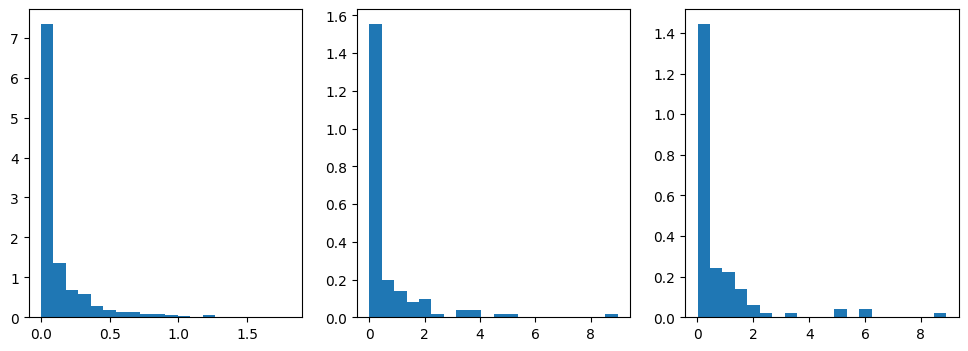

In [245]:
fig = plt.figure(figsize=(12, 4))
axs = fig.subplots(1, 3)

for i, split in enumerate(("train", "valid", "test")):
    dataset = split_to_dataset[split]
    y_true = transformers[0].untransform(dataset.y)
    y_pred = transformers[0].untransform(model.predict_on_batch(dataset.X))
    squared_errors = (y_true - y_pred)**2
    axs[i].hist(squared_errors, bins=20, density=True)

In [231]:
y_pred = model.predict_on_batch(test_dataset.X[:16])
for molecule, y_true, y_pred in zip(test_dataset.ids, test_dataset.y, y_pred):
    log_sol_true = transformers[0].untransform(y_true).item()
    log_sol_pred = transformers[0].untransform(y_pred).item()
    sol_true = np.exp(log_sol_true)
    sol_pred = np.exp(log_sol_pred)
    print(f"{molecule:60}: {log_sol_true:.4f} ({sol_true:.4f}), {log_sol_pred:.4f} ({sol_pred:.4f})")

ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl              : -6.2900 (0.0019), -6.6737 (0.0013)
CCCCCCCC(=O)OC                                              : -3.1700 (0.0420), -2.8783 (0.0562)
CN(C)C(=O)SCCCCOc1ccccc1                                    : -3.9270 (0.0197), -2.6222 (0.0726)
CCCCCCCI                                                    : -4.8100 (0.0081), -5.3164 (0.0049)
CC(C)OC=O                                                   : -0.6300 (0.5326), -0.2456 (0.7822)
c1ccccc1n2ncc(N)c(Br)c2(=O)                                 : -3.1270 (0.0438), -0.7096 (0.4919)
Cc1ccc(C)c2ccccc12                                          : -4.1400 (0.0159), -4.5145 (0.0109)
Cc1cc2c3ccccc3ccc2c4ccccc14                                 : -6.5700 (0.0014), -7.9646 (0.0003)
CCC(Br)(CC)C(=O)NC(N)=O                                     : -2.6800 (0.0686), -1.6996 (0.1828)
O=C2CN(N=Cc1ccc(o1)N(=O)=O)C(=O)N2                          : -3.3800 (0.0340), -1.5253 (0.2176)
CC(C)C(C(=O)OC(C#N)c1cccc(Oc2c

In [28]:
import os
os.environ['DEEPCHEM_DATA_DIR'] = "/home/rmrr/career/uncountable/data"

featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
splitter = "random"
# splitter = dc.splits.MolecularWeightSplitter()
transformers = ["normalization"]

tasks, datasets, transformers = dc.molnet.load_qm9(featurizer=featurizer, 
                                                   splitter=splitter,
                                                   transformers=transformers,
                                                   reload=True,
                                                   data_dir="data",
                                                   save_dir="data")

train_dataset, valid_dataset, test_dataset = datasets

In [30]:
train_dataset.get_shape()

((105576,), (105576, 12), (105576, 12), (105576,))

In [32]:
import wandb
from deepchem.models import WandbLogger

os.environ["WANDB_API_KEY"] = "#####"
wandb_logger = WandbLogger(project="deepchem")

In [33]:
BATCH_SIZE=32
# wandb_logger.experiment.config["batch_size"] = BATCH_SIZE

In [34]:
model = dc.models.torch_models.MPNNModel(n_tasks=1,
                                         node_out_feats = 64,
                                         edge_hidden_feats = 128,
                                         num_step_message_passing = 3,
                                         num_step_set2set = 6,
                                         num_layer_set2set = 3,
                                         mode = 'regression',
                                         number_atom_features = 30,
                                         number_bond_features = 11,
                                         self_loop= False,
                                         batch_size=BATCH_SIZE,
                                         model_dir="model",
                                         # wandb=True,
                                         learning_rate=0.001, 
                                         device="cpu",
                                         wandb_logger=wandb_logger)

In [35]:
loss = model.fit(train_dataset,
                 nb_epoch=10,
                 restore=False)

/home/rmrr/.conda/envs/deepchem/lib/python3.11/site-packages/deepchem/models/losses.py:90: UserWarning: Using a target size (torch.Size([32, 12])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.nn.functional.mse_loss(output,
/home/rmrr/.conda/envs/deepchem/lib/python3.11/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.ThreadPool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


KeyboardInterrupt: 

In [12]:
loss

0.2532390818876379

In [13]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.8369425954252208}
Test set score: {'pearson_r2_score': 0.6213956040328277}


In [15]:
solubilities = model.predict_on_batch(test_dataset.X[:10])
for molecule, y_pred, y in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(y_pred, y, molecule)

[-1.376157] [-1.60000553] c1cc2ccc3cccc4ccc(c1)c2c34
[0.52692] [0.20952792] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.68075764] [-0.01497035] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-1.6134826] [-2.82071486] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.1654787] [-0.52783277] C1=Cc2cccc3cccc1c23
[1.6020465] [1.10268267] CC1CO1
[-0.6525793] [-0.88877179] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-0.7522491] [-0.52541361] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-0.32961416] [-0.76249152] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[0.8767008] [-0.63911424] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 
